# Working with the Imaging pipeline



## What, and why?

The original goal of this project was to **improve data management within the Moser Group**. That's a very broad topic, and rather than reword it, I'll point you to the statement of intent that I previous wrote as part of the documentation (you may fnd this to be a running theme through this workshop): [Why should you care?](https://moser-pipelines.readthedocs.io/en/latest/common/getting_started/why.html)


If you publish research based on data that was acquired with the assistance of either RCN or EU funding, we are **legally obliged** to keep track of that data, and make it available on request. Consistent failure to do so puts at risk our ability to continue to win competitive funding.

Beyond our legal obligation, this group has a justifiably high reputation for the quality of our research - and that reputation will help you in your future careers. As members of the group, we share some responsibility for upholding that reputation. That doesn't just mean publishing in high profile journals - it means *being excellent scientists* - and speaking from experience, it really doesn't look good for us when requests for data can only be answered with "we have no idea where that data is any more".

This?

> `¯\_(ツ)_/¯`

Not a good look!


In a nutshell: because looking after your data while you're here is important to **you**, and after you leave; how well you have looked after your data is important to **us**.




## Minimum requirements

The statement previously made by May-Britt and Edvard is:

> Datajoint serves several purposes. **Cataloging** your research data via Datajoint is a **requirement** of your role in the research group. Analysing your data via datajoint is **optional** but **encouraged**

Cataloging your data is not just about making life easier for you (although it absolutely will!). Your research data comes at considerable cost - public money; the lives of our mice and rats; and (not least) your time and energy. It is incumbent upon all of us to make best use of the data after that cost:





## Key links
| Key | Links |
|--------------------------------|---------------------------------------|
| Moser Pipeline documentation | [ReadTheDocs](https://moser-pipelines.readthedocs.io/en/latest/index.html) |
| Adding new data | [Web interface](https://datajoint.kavli.org.ntnu.no/) |
| Imaging pipeline code | [dj-imaging](https://github.com/kavli-ntnu/dj-imaging) |
| Analysis code | [opexebo](https://github.com/kavli-ntnu/opexebo) |
| Analysis code documentation | [ReadTheDocs](https://opexebo.readthedocs.io/en/latest/index.html) |

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt

In [2]:
animal = dj.create_virtual_module('animal', 'prod_mlims_data')
imaging = dj.create_virtual_module("imaging", "group_shared_imaging")

Connecting simoba@datajoint.it.ntnu.no:3306


# The core components of the pipeline that you probably care about the most

An overview of the core workflow of the pipeline:

The first point of entry for new data is the [Web interface](https://datajoint.kavli.org.ntnu.no/imaging/basefolders/add_basefolder), where the user adds a new **BaseFolder**. A BaseFolder is a location on a network drive containing a group of recordings. Depending on the value of _Combined_, all data will be processed via Suite2P together (_Combined_ = Yes) or seperately per Recording (_Combined_ = No)

The web gui has a [documented user guide](https://moser-pipelines.readthedocs.io/en/latest/imaging/how-to-add-sessions.html).

In [3]:
Image(url= "https://moser-pipelines.readthedocs.io/en/latest/_images/gui_basefolder_example.png")

A background worker will pick up the new BaseFolder and analyse files that are present:
* The name(s) of the Session(s) involved in the Basefolder will be checked
    * If the name is **new**, new Session and Recording entries will be created
    * If the name **already exists**, the BaseFolder will be checked for changes
* New Recordings that are attached to those Sessions will be created
* Image data stored as either `.tif` or `.mesc` data will be identified
* Tracking data stored in various formats will be identified
* Sync data will be identified
* The presence or absence of Suite2p data will be identified
    * If absent, the Session will be queued for background Suite2P processing


**The same BaseFolder may safely be added via the web interface multiple times.** Duplicate sessions are identified  and avoided via a unique name (derived from the path to the basefolder). If the data in a BaseFolder _changes_ for example, by re-running or curating Suite2P, then the correct workflow is to **add the Basefolder to the web interface again**. 

## Core tables: Session to SignalTracking



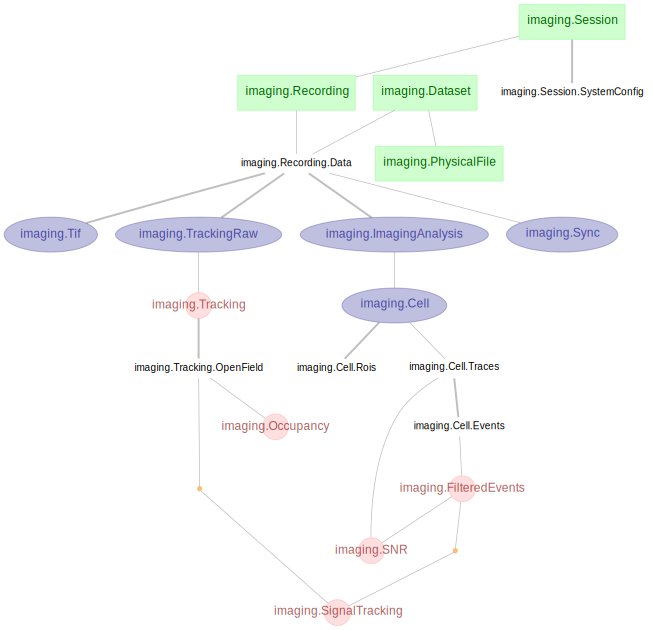

In [4]:
(
    dj.Diagram(imaging.Session)
    + imaging.Session.SystemConfig
    + imaging.Dataset
    + imaging.PhysicalFile
    + imaging.Recording
    + imaging.Recording.Data
    + imaging.Tif
    + imaging.Sync
    + imaging.ImagingAnalysis
    + imaging.Cell
    + imaging.Cell.Traces
    + imaging.Cell.Events
    + imaging.Cell.Rois
    + imaging.FilteredEvents
    + imaging.SNR
    + imaging.TrackingRaw
    + imaging.Tracking
    + imaging.Tracking.OpenField
    + imaging.Occupancy
    + imaging.SignalTracking
)

An overview of the contents of these tables is given [in the pipeline documentation](https://moser-pipelines.readthedocs.io/en/latest/imaging/table-overview.html).

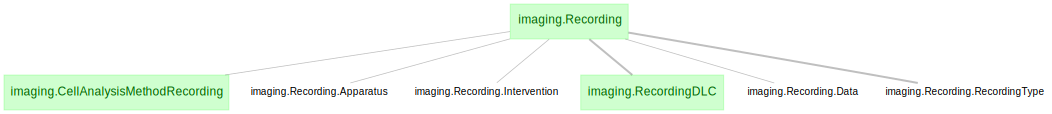

In [5]:
dj.ERD(imaging.Recording) +1

## Extracted Data Section

A large part of the pipeline revolves around extracting data from the raw data files, (minimally) post-processing it and making it more easily available than diving back to the raw data files yourself. 

This section tires to impose as few _assumptions_ about your data as possible, and simply make it more easily available - both for later analysis within the pipeline; or for users to run their own analysis on it.

1. Identifyng a Recording
2. Checking what data is present
3. Extracting data from the pipeline to work with
4. Sync data
5. Tracking data
6. Cell data


### Identifying a Recording

The most common entry point to the imaging database will be the `imaging.Recording` table, which matches a `recording_name` to an `animal_name` and a `timestamp`. A common activity will be, for example, identifyng all of the Recordings attached to a particular animal. 

In [6]:
imaging.Recording & {"animal_name":100602}

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp Timestamp of recording,combined,timeseries_name Timeseries name [e.g. MUnit_0],equipment_type,username NTNU username
045834456c82627d,0,ae8c798a42d96609,56836192ac394f0f,0,100602,2022-05-16 12:17:04,yes,100602-OF-ML+400-AP000,2Pminiscope_B,martipof
0a59dac1dcba870a,0,d25b179a25df97d0,56836192ac394f0f,0,100602,2022-06-07 14:53:11,yes,100602-OF-AP-400-ML000,2Pminiscope_B,martipof
0a59dac1dcba870a,1,77c359b0f9a21962,56836192ac394f0f,0,100602,2022-06-07 15:29:13,yes,100602-Obj1-AP-400-ML000,2Pminiscope_B,martipof
0a59dac1dcba870a,2,e94448f91587aa72,56836192ac394f0f,0,100602,2022-06-07 16:07:32,yes,100602-Obj2-AP-400-ML000,2Pminiscope_B,martipof
0c61c90103628c7d,0,b869aad8064d83ad,56836192ac394f0f,0,100602,2022-05-05 17:08:51,yes,100602-OF-AP+0-ML+0,2Pminiscope_B,martipof
1047b28c84e4ed40,0,2823657001a1d9b2,56836192ac394f0f,0,100602,2022-06-02 09:31:10,yes,100602-OF-AP-400-ML-400,2Pminiscope_B,martipof
1047b28c84e4ed40,1,86f31861fc04d3c8,56836192ac394f0f,0,100602,2022-06-02 10:41:57,yes,100602-Obj1-AP-400-ML-400,2Pminiscope_B,martipof


You might want to search by other criteria. Both `imaging.Session` and `imaging.Recording` have several sub-tables that track various other aspects about the data

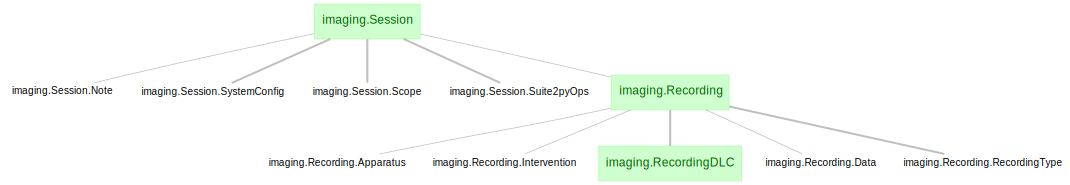

In [7]:
(dj.Diagram(imaging.Recording) +1 - imaging.CellAnalysisMethodRecording) + (dj.Diagram(imaging.Session) + 1) 

In [8]:
(
    imaging.Recording
    * imaging.Recording.RecordingType
    * imaging.Recording.Apparatus
    & {"animal_name":100602, "recording_type": "Open Field Object", "apparatus": "Square80"}
)

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",apparatus,"category Arena / Apparatus category (openfield, linear track, etc.)",animal_id,datasource_id,animal_name Animal name in mlims,timestamp Timestamp of recording,combined,timeseries_name Timeseries name [e.g. MUnit_0],equipment_type,username NTNU username,recording_type Name for Recording Type
0a59dac1dcba870a,1,77c359b0f9a21962,Square80,Open Field,56836192ac394f0f,0,100602,2022-06-07 15:29:13,yes,100602-Obj1-AP-400-ML000,2Pminiscope_B,martipof,Open Field Object
0a59dac1dcba870a,2,e94448f91587aa72,Square80,Open Field,56836192ac394f0f,0,100602,2022-06-07 16:07:32,yes,100602-Obj2-AP-400-ML000,2Pminiscope_B,martipof,Open Field Object
1047b28c84e4ed40,1,86f31861fc04d3c8,Square80,Open Field,56836192ac394f0f,0,100602,2022-06-02 10:41:57,yes,100602-Obj1-AP-400-ML-400,2Pminiscope_B,martipof,Open Field Object
1047b28c84e4ed40,2,2c909bc0aca02535,Square80,Open Field,56836192ac394f0f,0,100602,2022-06-02 11:45:57,yes,100602-Obj2-AP-400-ML-400,2Pminiscope_B,martipof,Open Field Object
1944ece4571af87c,1,8dfc2062b9392a07,Square80,Open Field,56836192ac394f0f,0,100602,2022-10-04 15:20:09,yes,100602-Obj1-AP-400-ML+400,2Pminiscope_B,martipof,Open Field Object
1944ece4571af87c,2,b138434a773f8470,Square80,Open Field,56836192ac394f0f,0,100602,2022-10-04 15:58:02,yes,100602-Obj2-AP-400-ML+400,2Pminiscope_B,martipof,Open Field Object
1a8b4059b2c38cec,1,0747afc78ef205e7,Square80,Open Field,56836192ac394f0f,0,100602,2022-06-08 11:08:45,yes,100602-Obj1-AP-400-ML+400,2Pminiscope_B,martipof,Open Field Object


### Checking what data is attached to a Recording

The Imaging pipeline tracks the physical files on disk associated with a Recording, and groups them together in **Datasets**. For example, in a long recording, your imaging data my be split into 2 or more `.tif` files, which need to be analysed together to reproduce a single, coherent, collection of two-photon data.

Note that the Imaging pipeline tracks _known file types_. While it will enumerate every file within a BaseFolder, it will only track files which match known criteria. Files that do not match any known criteria may be present and will be **ignored** by the pipeline. 

These entities are tracked in three tables: 
* `imaging.Dataset` provides a label for a set of files that will be tracked together
* `imaging.PhysicalFile` has a row for each file on disk that is tracked, and links it to a row in `imaging.Dataset`
* `imaging.Recording.Data` links entries in `imaging.Dataset` to that specific recording.

We can then use these tables to inspect what data is known to the pipeline. Let's pick a single (arbitrary) recording by name

In [9]:
my_recording = {"recording_name":"d25b179a25df97d0"}
imaging.Recording & my_recording

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp Timestamp of recording,combined,timeseries_name Timeseries name [e.g. MUnit_0],equipment_type,username NTNU username
0a59dac1dcba870a,0,d25b179a25df97d0,56836192ac394f0f,0,100602,2022-06-07 14:53:11,yes,100602-OF-AP-400-ML000,2Pminiscope_B,martipof


In [10]:
imaging.Recording.Data & my_recording

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5
0a59dac1dcba870a,0,d25b179a25df97d0,3408b6ea16a58b94
0a59dac1dcba870a,0,d25b179a25df97d0,50a752efbc310a26
0a59dac1dcba870a,0,d25b179a25df97d0,8976b40c7f808930
0a59dac1dcba870a,0,d25b179a25df97d0,a120eeca5e7d1507
0a59dac1dcba870a,0,d25b179a25df97d0,a540da4d3a142f07


By itself, that doesn't tell us much. We can join with the other two listed tables to see more information about those datasets, and the files involved

In [11]:
(
    imaging.Recording.Data
    * imaging.Dataset
    * imaging.PhysicalFile
    & my_recording
)

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,filetype Name for filetype,file_order Order of a file among other files in the same dataset,datasettype Name for Dataset Type,repository_name Short name for repository,file_path File path on repository
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_F,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/F.npy
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_Fneu,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/Fneu.npy
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_iscell,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/iscell.npy
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_ops,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/ops.npy
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_redcell,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/redcell.npy
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_spks,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/spks.npy
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,Suite2py_stat,0,Suite2py_combined,extopo,Imaging/2pmini/100602/07062022/combined_0a59dac1dcba870a/mini2p_GC8_ch2/combined/stat.npy


### Extracting data to work with

So far, we have only displayed a _sample_ of data stored in the pipeline on screen. It's no good to actually do your own calculations with. A more thorough explanation on this topic is given [in the documentation](https://moser-pipelines.readthedocs.io/en/latest/common/common_operations.html).

Datajoint implements two methods for actually **fetching** the data itself:
* `.fetch()`
* `.fetch1()`

`.fetch()` will work on whatever query object it is applied to, and will fetch 0, 1, or many entries. `.fetch1()` will explicitly fetch only one entry, and will raise an error if the query object contains either more or less than one entry.

In [12]:
# Trying to fetch a single row from a query with many rows. This will cause an error!
imaging.Recording.fetch1()

DataJointError: fetch1 should only be used for relations with exactly one tuple

In [13]:
(imaging.Recording & my_recording).fetch1()

{'session_name': '0a59dac1dcba870a',
 'recording_order': 0,
 'recording_name': 'd25b179a25df97d0',
 'animal_id': '56836192ac394f0f',
 'datasource_id': 0,
 'animal_name': '100602',
 'timestamp': datetime.datetime(2022, 6, 7, 14, 53, 11),
 'combined': 'yes',
 'timeseries_name': '100602-OF-AP-400-ML000',
 'equipment_type': '2Pminiscope_B',
 'username': 'martipof'}

In [14]:
multiple_data = (imaging.Recording & {"animal_name":100602}).fetch()
print(type(multiple_data))
multiple_data[0]

<class 'numpy.ndarray'>


('045834456c82627d', 0, 'ae8c798a42d96609', '56836192ac394f0f', 0, '100602', datetime.datetime(2022, 5, 16, 12, 17, 4), 'yes', '100602-OF-ML+400-AP000', '2Pminiscope_B', 'martipof')

We can control how data is returned:
* We can request specific columns, vs the entire row
* We can specify what format the data is returned in (dict, ordered tuple, pandas dataframe)
* We can specify a maximum number of rows to fetch
* We can specify the order in which rows are fetched

In [15]:
imaging.Recording.fetch("timestamp", order_by="timestamp DESC", limit=5, as_dict=True)

[{'timestamp': datetime.datetime(2022, 10, 27, 16, 37, 2)},
 {'timestamp': datetime.datetime(2022, 10, 27, 16, 11, 12)},
 {'timestamp': datetime.datetime(2022, 10, 27, 15, 40, 9)},
 {'timestamp': datetime.datetime(2022, 10, 27, 12, 43, 21)},
 {'timestamp': datetime.datetime(2022, 10, 26, 16, 13, 56)}]

### Dealing with Sync data

Due to the more experimental nature of two photon hardware, synchronisation between multiple instruments has generally been more varied within the imaging research team than the ephys team, and synchronisation is necessarily a more complex topic here. However, it has been standardised somewhat with the rollout of the openmini2p systems.

A more thorough explanation is given [in the documentation](https://moser-pipelines.readthedocs.io/en/latest/imaging/sync.html)

In general, for each additional instrument synchronised, an additional "sync stream" will be attached to a Recording. Each sync stream is a 1D array of timestamps at which "something" happened for that instrument  (where that "something" could be, e.g., a frame from the tacking camera, or the start of a laser scan, or a tick of a rotary encoder, etc etc)

Synchronisation data is ingested into the `imaging.Sync` table

In [16]:
imaging.Sync()

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,sync_name Name of sync stream,num_indices Total number of indices,sync_data Indices over all subsessions,sample_rate Sample rate,lengths Sample lengths of all subsessions,sample_boundaries Array of sample boundaries for each subsession,timestamp Timestamp of acquisition,entry_time_sync Auto created timestamp
045834456c82627d,0,ae8c798a42d96609,29a554f1da806b77,aux_0,124273,=BLOB=,1.0,=BLOB=,=BLOB=,2022-05-16 12:17:04,2022-05-25 21:11:10
045834456c82627d,0,ae8c798a42d96609,29a554f1da806b77,frames,23400,=BLOB=,1.0,=BLOB=,=BLOB=,2022-05-16 12:17:04,2022-05-25 21:11:10
045834456c82627d,0,ae8c798a42d96609,29a554f1da806b77,planes,23400,=BLOB=,1.0,=BLOB=,=BLOB=,2022-05-16 12:17:04,2022-05-25 21:11:10
061c4d37625bb51a,0,e9a4892d1595af7a,8c4ce60d56974e8d,aux_0,74221,=BLOB=,1.0,=BLOB=,=BLOB=,2022-07-29 12:10:05,2022-08-01 15:51:26
061c4d37625bb51a,0,e9a4892d1595af7a,8c4ce60d56974e8d,frames,27000,=BLOB=,1.0,=BLOB=,=BLOB=,2022-07-29 12:10:05,2022-08-01 15:51:26
061c4d37625bb51a,0,e9a4892d1595af7a,8c4ce60d56974e8d,planes,27000,=BLOB=,1.0,=BLOB=,=BLOB=,2022-07-29 12:10:05,2022-08-01 15:51:26
0a59dac1dcba870a,0,d25b179a25df97d0,8976b40c7f808930,aux_0,73775,=BLOB=,1.0,=BLOB=,=BLOB=,2022-06-07 14:53:11,2022-06-08 10:17:53


Any given Recording may have multiple sync datasets, typically called "sync streams", distinguished by column `sync_name`. The length of the sync stream is indicated by `num_indicies`. The value `sample_rate` can be confusing for Openmini2p recordings, as its value of 1.0 generally means that it was "pre-synchronised", rather than a 1Hz sample rate. 

For OpenMini2p systems, there will always be at least two streams, named `frames` and `planes`.
* `planes` : a timestamp is added each time the mems scanner begins a new scan
* `frames` : a timestamp is added each time the zoom lens resets to the first z-layer _and_ the mems scanner begins a new scan (i.e. starting a new _volume_)

For single-plane data, both time streams will be identical in length and value. For multiple plane data, the `frames` array with be shorter by an integer factor equal to the number of planes imaged. 

In [17]:
imaging.Sync & my_recording

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,sync_name Name of sync stream,num_indices Total number of indices,sync_data Indices over all subsessions,sample_rate Sample rate,lengths Sample lengths of all subsessions,sample_boundaries Array of sample boundaries for each subsession,timestamp Timestamp of acquisition,entry_time_sync Auto created timestamp
0a59dac1dcba870a,0,d25b179a25df97d0,8976b40c7f808930,aux_0,73775,=BLOB=,1.0,=BLOB=,=BLOB=,2022-06-07 14:53:11,2022-06-08 10:17:53
0a59dac1dcba870a,0,d25b179a25df97d0,8976b40c7f808930,frames,13500,=BLOB=,1.0,=BLOB=,=BLOB=,2022-06-07 14:53:11,2022-06-08 10:17:53
0a59dac1dcba870a,0,d25b179a25df97d0,8976b40c7f808930,planes,27000,=BLOB=,1.0,=BLOB=,=BLOB=,2022-06-07 14:53:11,2022-06-08 10:17:53


Notice that the data preview doesn't preview any of the more complicated/bulky data (under `sync_data` is simply "=blob="). We have to fetch the data itself to inspect it
    

In [18]:
sync_data = (imaging.Sync & my_recording).fetch("sync_name", "sync_data", "num_indices", as_dict=True)

In [19]:
sync_data[1]

{'sync_name': 'frames',
 'num_indices': 13500,
 'sync_data': array([0.00000000e+00, 1.38000005e-01, 2.75999985e-01, ...,
        1.86258600e+03, 1.86272400e+03, 1.86286200e+03])}

In [20]:
sync_data[2]

{'sync_name': 'planes',
 'num_indices': 27000,
 'sync_data': array([0.00000000e+00, 6.90000150e-02, 1.38000005e-01, ...,
        1.86279300e+03, 1.86286200e+03, 1.86293100e+03])}

### Tracking Data

Tracking data is stored in two major tables, and (dependning on type) several sub-tables.

Raw tracking data, in whatever form is produced by the tracking system, is ingested into the table `imaging.TrackingRaw`. This will commonly be in arbitrary units (e.g. camera pixels). Tracking data is then processed into SI units, typically millimetres, and stored in the `imaging.Tracking` table.

In both cases, the "parent" table (`imaging.TrackingRaw`, `imaging.Tracking`) stores information common to multiple tracking systems, while specific information is stored in one of the sub tables.
* start, stop, timestamp, sample rate are stored in `imaging.TrackingRaw`
* x, y, boundary limits, etc are stored in `imaging.TrackingRaw.OpenField`
* Relative position, number of laps etc are stored in `imaging.TrackingRaw.Linear`.

For post analysis, you will typically want to deal with the `imaging.Tracking` (and sub tables) rather than `imaging.TrackingRaw`.

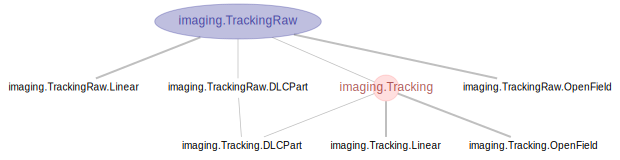

In [21]:
(dj.Diagram(imaging.TrackingRaw) + 1 ) + (dj.Diagram(imaging.Tracking) + 1)

In [22]:
imaging.TrackingRaw()

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,start_time Registered system start time,stop_time Registered system stop time,timestamps Timestamps in seconds - synced timestamps,timestamps_sys Timestamps in seconds - explicitly derived from system clock,sample_rate Sampling rate,sync Was a sync signal considered? (0=no / 1=yes),is_calibrated Was calibration (conversion px -> mm) applied?,entry_time_tracking_raw Auto created timestamp
061c4d37625bb51a,0,e9a4892d1595af7a,f3f74d95f9552a05,2022-07-29 12:10:05,2022-07-29 12:41:08,=BLOB=,=BLOB=,39.891853756024915,1,0,2022-08-01 17:13:40
0a59dac1dcba870a,0,d25b179a25df97d0,a120eeca5e7d1507,2022-06-07 14:53:11,2022-06-07 15:24:14,=BLOB=,=BLOB=,39.71895501158254,1,0,2022-06-08 10:40:34
0a59dac1dcba870a,1,77c359b0f9a21962,3841666f4b50b310,2022-06-07 15:29:13,2022-06-07 16:00:16,=BLOB=,=BLOB=,39.71591969549146,1,0,2022-06-08 11:16:48
0a59dac1dcba870a,2,e94448f91587aa72,76f6e8671e049673,2022-06-07 16:07:32,2022-06-07 16:38:35,=BLOB=,=BLOB=,39.804097840442644,1,0,2022-06-08 11:57:13
0c61c90103628c7d,0,b869aad8064d83ad,817d713bb582e6ff,2022-05-05 17:08:51,2022-05-05 18:11:39,=BLOB=,=BLOB=,39.94967900152068,1,0,2022-05-28 04:59:58
1047b28c84e4ed40,0,2823657001a1d9b2,299333d47a051179,2022-06-02 09:31:10,2022-06-02 10:31:01,=BLOB=,=BLOB=,39.92112178323249,1,0,2022-06-07 22:03:36
1047b28c84e4ed40,1,86f31861fc04d3c8,50b81cc45bf13f63,2022-06-02 10:41:57,2022-06-02 11:41:48,=BLOB=,=BLOB=,39.918659526434006,1,0,2022-06-07 20:59:22


In [23]:
imaging.TrackingRaw.OpenField()

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,x_pos Tracking x position (px),y_pos Tracking y position (px),boundary_left Extracted boundary towards left (px),boundary_right Extracted boundary towards right (px),boundary_bottom Extracted boundary towards bottom (px),boundary_top Extracted boundary towards top (px),speed Speed (px/s),"head_angle Head angle [0,2*pi]",x_offset,y_offset
061c4d37625bb51a,0,e9a4892d1595af7a,f3f74d95f9552a05,=BLOB=,=BLOB=,8.194603145122528,951.6209697555751,15.316535785794258,964.116160467267,=BLOB=,=BLOB=,144.69385087490082,154.40079134702682
0a59dac1dcba870a,0,d25b179a25df97d0,a120eeca5e7d1507,=BLOB=,=BLOB=,7.48946717712613,937.1136232018471,10.569102764129639,940.7851451933384,=BLOB=,=BLOB=,177.45647406578064,156.1728972196579
0a59dac1dcba870a,1,77c359b0f9a21962,3841666f4b50b310,=BLOB=,=BLOB=,15.748226448893547,937.5270693004131,12.60555249452591,938.6753222942352,=BLOB=,=BLOB=,172.69745421409607,155.170296728611
0a59dac1dcba870a,2,e94448f91587aa72,76f6e8671e049673,=BLOB=,=BLOB=,8.768856287002563,932.4483082816005,53.34349834918976,977.4889861643314,=BLOB=,=BLOB=,179.21098804473877,116.09308975934982
0c61c90103628c7d,0,b869aad8064d83ad,817d713bb582e6ff,=BLOB=,=BLOB=,10.690290227532387,1176.624060317874,88.37810698151588,1246.667300275527,=BLOB=,=BLOB=,96.92884719371796,58.9647222161293
1047b28c84e4ed40,0,2823657001a1d9b2,299333d47a051179,=BLOB=,=BLOB=,11.106790482997894,948.1263030171394,108.37819914519787,1060.2484498023987,=BLOB=,=BLOB=,205.54733127355576,38.28695583343506
1047b28c84e4ed40,1,86f31861fc04d3c8,50b81cc45bf13f63,=BLOB=,=BLOB=,11.86123526096344,937.9979122877121,64.97731149196625,992.8818386793137,=BLOB=,=BLOB=,211.84229385852814,104.45161664485931


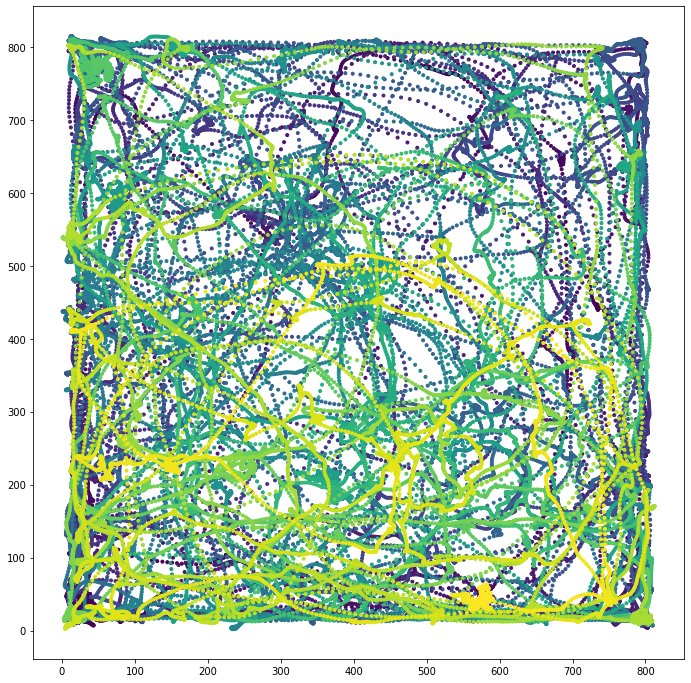

In [24]:
ts = (imaging.TrackingRaw & my_recording).fetch1("timestamps")
ts_norm = (ts - ts.min()) / (ts.max() - ts.min())
x, y = (imaging.Tracking.OpenField & my_recording).fetch1("x_pos", "y_pos")
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x, y, c=ts_norm, marker=".", cmap="viridis")
ax.set_aspect(1)


### Cell Data

Per-cell data is stored in and downstream of the `imaging.Cell` table. `imaging.Cell` has three important sub-tables that you will need to work with:

* `imaging.Cell` itself tracks cell_id, the plane on which the cell was identified
* `imaging.Cell.Rois` tracks the ROI associated with the primary channel of that cell
* `imaging.Cell.Traces` tracks the fluoresence, neuropil, neurpil corrected fluoresence, and df/f traces per cell, per channel (primary/secondary)
* `imaging.Cell.Events` tracks the unfiltered deconvolved spike train (as generated by Suite2p)

Deconvolved spike events are then filtered and stored in the `imaging.FilteredEvents` table. Users may configure _how_ they want their spikes to be filtered via EventFilterParams

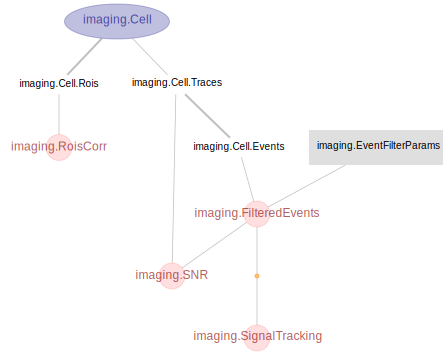

In [25]:
dj.Diagram(imaging.Cell)+4 + imaging.EventFilterParams

Text(0.5, 0, 'Time [s]')

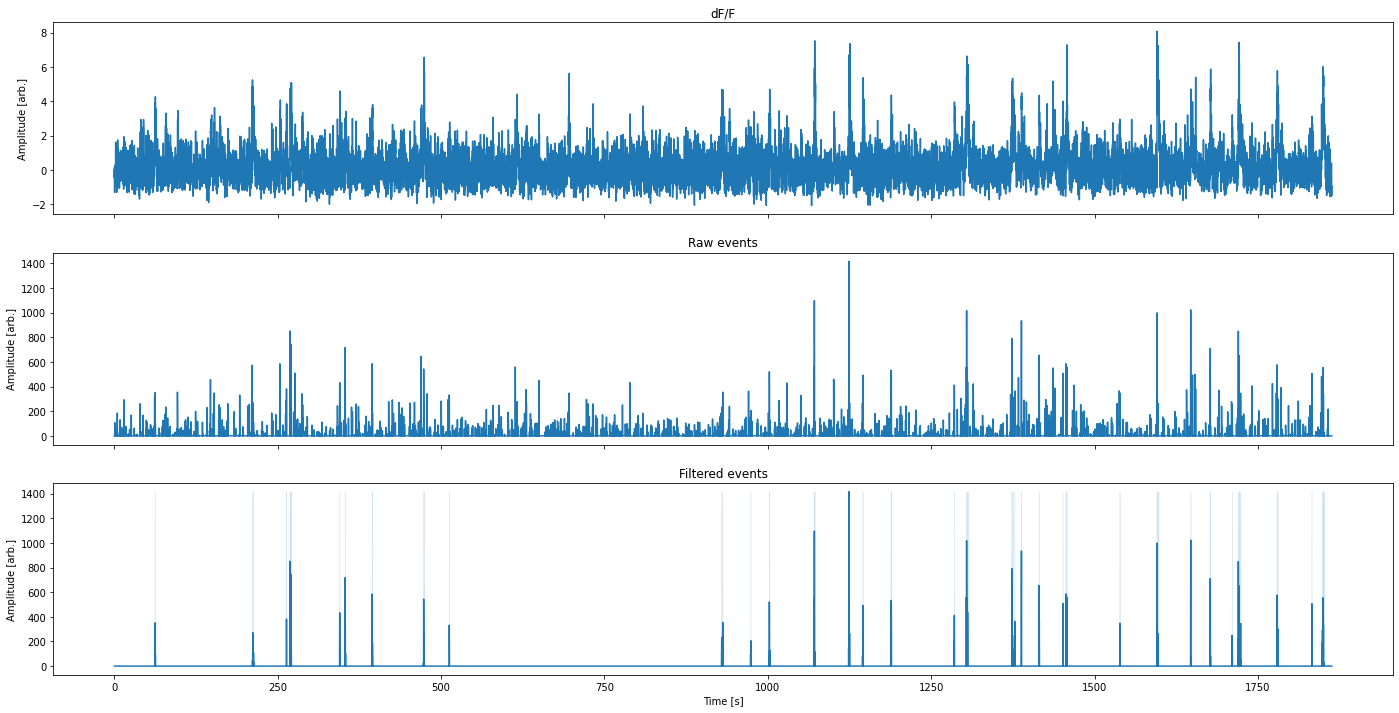

In [26]:
my_cell = {**my_recording, "cell_id": 7, "channel": "primary"}
sync = (imaging.Sync & my_recording & {"sync_name":"frames"}).fetch1("sync_data")
df_f = (imaging.Cell.Traces & my_cell).fetch1("df_f")
events_raw = (imaging.Cell.Events & my_cell).fetch1("events")
events_filt, events_mask = (imaging.FilteredEvents & my_cell).fetch1("filtered_events", "mask_events")


fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(24,12))
ax[0].plot(sync, df_f)
ax[0].set_title("dF/F")
ax[0].set_ylabel("Amplitude [arb.]")

ax[1].plot(sync, events_raw)
ax[1].set_title("Raw events")
ax[1].set_ylabel("Amplitude [arb.]")

ax[2].plot(sync, events_filt)
ax[2].fill_between(sync, events_mask.astype(int)*events_filt.max(), alpha=0.2)
ax[2].set_title("Filtered events")
ax[2].set_ylabel("Amplitude [arb.]")
ax[2].set_xlabel("Time [s]")

### SignalTracking

Signaltracking is the last table in the "data extraction" part of the pipeline: everything afterwards is firmly into the field of analysis. SignalTracking matches the animal's spatial behaviour to its cell activity.

For each cell, the spatial data is matched to both dF/F and filtered events

In [27]:
imaging.SignalTracking & my_cell

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",signal_dataset 16 character hash,cell_id Cell ID,channel the channel that this trace comes from (ROI masks are always primary),"event_filter_id Parameter set ID, starting with A",tracking_dataset 16 character hash,"trackingparams_id Parameter set ID, starting with A","s_t_params_id Parameter set ID, starting with A",signal_type Signal type (Fluorescence vs. events),signal Signal (events/calcium) amplitudes,x_pos_signal Tracking x position for signal (center of 2 LEDs),y_pos_signal Tracking y position for signal (center of 2 LEDs),speed_signal Speed in pixels / sec for signal,"head_angle_signal Head angle [0,2*pi] for signal",filtered_idxs_signal Filtered indices in signal,filtered_idxs_tracking Filtered indices in tracking,filtered_signal_count Number of remaining signal datapoints after filtering
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,7,primary,A,a120eeca5e7d1507,A,A,df_f,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,13349
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,7,primary,A,a120eeca5e7d1507,A,A,events,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,144


## Analysis Section

Distinct from the "Extracted Data section", the Analysis section performs assorted calculatons on the raw data.

This section is the most optional section of the pipeline: I _hope_ that it is useful to you, but it runs the greatest risk of being seen as a "black box".

I want to emphasise that _it is not a black box_. _All_ of the code that is used in the pipeline is available to all members of the Kavli Institute (not just the Moser group) ([GitHub](https://github.com/kavli-ntnu/dj-imaging)); and in the event of uncertainty, you can (and should!) investigate in depth:
* You can fetch the same data that the pipeline code will be run on from earlier tables
* You can read the code directly, either to check for obvious errors or as inspiration for your own analysis
* You can run the same testing and verification proceedures that you would apply to your own code (you do validate your own code, right?)

I cannot guarantee that all code is bug free: anyone who aims to tell you that is selling you something.

But I can guarantee that, by having a larger number of people testing these common routines and pooling their findings; it will contain fewer bugs on average than if everyone writes their own version of the same analyses, doing the same things, in slightly different ways

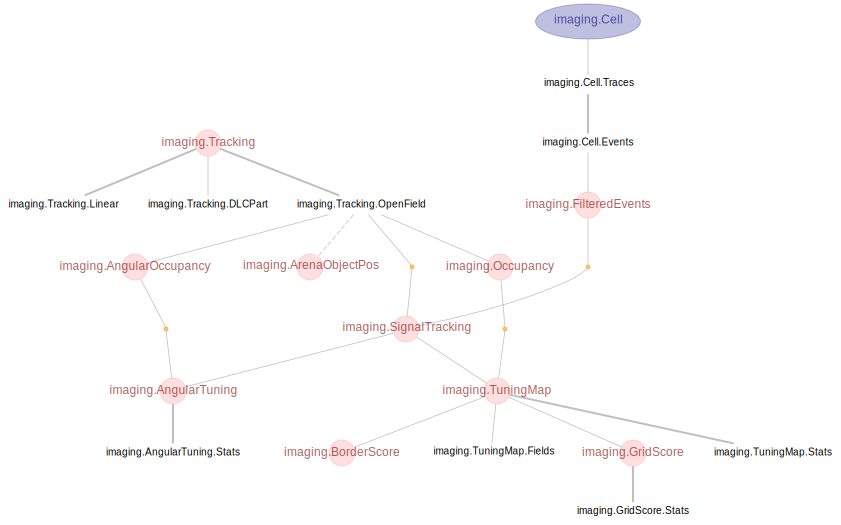

In [28]:
(
    (dj.Diagram(imaging.Tracking) + 5)
    + imaging.Cell
    + imaging.Cell.Traces
    + imaging.Cell.Events
    + imaging.FilteredEvents
)


In [29]:
(imaging.TuningMap & my_cell)

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",signal_dataset 16 character hash,cell_id Cell ID,channel the channel that this trace comes from (ROI masks are always primary),"event_filter_id Parameter set ID, starting with A",tracking_dataset 16 character hash,"trackingparams_id Parameter set ID, starting with A","s_t_params_id Parameter set ID, starting with A",signal_type Signal type (Fluorescence vs. events),"map_params_id Parameter set ID, starting with A","field_params_id Parameter set ID, starting with A",tuningmap Smoothed 2D tuningmap,tuningmap_raw Unsmoothed (raw) 2D tuningmap,mask_tm Mask (where time = 0),"binned_raw Raw, binned signal",bin_max Bin with maximum signal (tuningmap(bin_max) = max(tuningmap)),max Maximum,no_fields Total number of detected fields,fields_map Map of detected fields
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,7,primary,A,a120eeca5e7d1507,A,A,df_f,A,A,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,3.8374978954553,4,=BLOB=
0a59dac1dcba870a,0,d25b179a25df97d0,03801e6436fdcef5,7,primary,A,a120eeca5e7d1507,A,A,events,A,A,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,98.6056358967551,6,=BLOB=


2


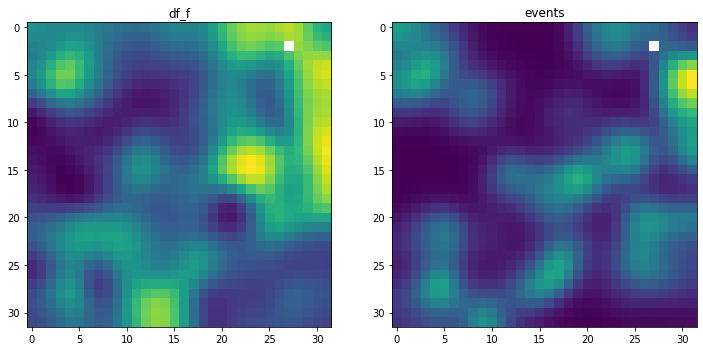

In [30]:
rows = (imaging.TuningMap & my_cell).fetch()
print(len(rows))
fig, ax = plt.subplots(ncols=2, figsize=(12, 7))
for i, tm in enumerate(rows):
    masked_tm = np.ma.masked_where(tm["mask_tm"], tm["tuningmap"])
    ax[i].imshow(masked_tm)
    ax[i].set_aspect(1)
    ax[i].set_title(tm["signal_type"])


### Restricting by analyses

The most important part of storing data in a structured format, is that it makes searching _significantly_ easier. Thus far, we have picked a Recording and random, and gone from there. But we can search for far more complex restrictions

Of all of the data in the imaging pipeline (which is not very much), which cells have the largest number of fields?

In [31]:
# fields are tracking in `imaging.TuningMap`
highest_fn_key = imaging.TuningMap.fetch("KEY", limit=1, order_by="no_fields DESC")
imaging.Cell & highest_fn_key

session_name Session name (hash),recording_order Order of Recording within Session (zero index!),"recording_name Recording name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",dataset_name 16 character hash,cell_id Cell ID,center_plane Imaging plane of this cell,"timestamps Synchronized timestamps of the activity traces for a cell, accounted for timeshift based on cell location"
ebb66ef8dd8bba16,0,d24f0420e5f84f92,6f4481e516a8547a,316,0,=BLOB=


What animal has the cell with the highest gridscore in the pipeline? Show me it's tuning map

Text(0.5, 1.0, '88592')

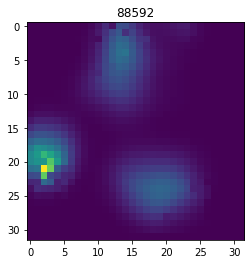

In [32]:
# gridscore is tracked in `imaging.GridScore`
highest_gn_key = imaging.GridScore.fetch("KEY", limit=1, order_by="gridscore DESC")
animal_name = (imaging.Recording & highest_gn_key).fetch1("animal_name")
tm = (imaging.TuningMap & highest_gn_key).fetch1()
plt.imshow(tm["tuningmap"])
plt.title(animal_name)

Which animal explores its environments most
* thoroughly?
* consistently?
(nb: these questions are significantly dependent on parameters, e.g., binning of the arena. As the bin size tends to infinitesimal, the explore fraction will do likewise)

In [33]:
# Pick a single set of binning params for consistency. Technically optional since there only *is* one set right now!
# Thoroughly - that's easy, get the highest exploration ratio just as we did with gs
binning_params = {"map_params_id":"A"}
highest_explore_key, ratio = (imaging.Occupancy & binning_params).fetch("KEY", "explor_ratio", limit=1, order_by="explor_ratio DESC")
animal_name = (imaging.Recording & highest_explore_key).fetch1("animal_name")
print("Animal '{}' explored the most ({:.2f} %)".format(animal_name, float(ratio[0]*100)))

Animal '102931' explored the most (100.00 %)


In [34]:
# Most consistently - more interesting!
# Arbitrarily, let's assert that `xplor_ratio` is normally distributed. Therefore, we can find the smallest standard deviation
# We could do this purely in Python as an example:
all_animal_names = set(imaging.Recording.fetch("animal_name"))
out = {}
lowest_std = None
lowest_std_an = None
for an in all_animal_names:
    all_occupancies = ((imaging.Recording & {"animal_name":an}) * imaging.Occupancy).fetch("explor_ratio")
    std = all_occupancies.std()
    out[an] = {
        "num_recordings": len(all_occupancies),
        "stdev": std,
        "avg": all_occupancies.mean()
    }
    if lowest_std is None:
        lowest_std = std
        lowest_std_an = an
    elif std < lowest_std:
        lowest_std = std
        lowest_std_an = an
print("Animal '{}' was most consistent ({:.2f} +- {:.2f} % over {} recs)".format(
        lowest_std_an,
        out[lowest_std_an]["avg"],
        lowest_std,
        out[lowest_std_an]["num_recordings"],
))
out

Animal '88592' was most consistent (0.84 +- 0.00 % over 1 recs)


/Users/simoba/opt/anaconda3/envs/dj-imaging/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/simoba/opt/anaconda3/envs/dj-imaging/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/simoba/opt/anaconda3/envs/dj-imaging/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/c6/dd3tf28138xdp_hk3vxrrytw0000gn/T/ipykernel_36820/701248632.py:14: RuntimeWarning: Mean of empty slice.
  "avg": all_occupancies.mean()
/Users/simoba/opt/anaconda3/envs/dj-imaging/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/simoba/opt/anaconda3/envs/dj-imaging/lib/python3.8/si

{'103564': {'num_recordings': 4,
  'stdev': 0.027821276705068718,
  'avg': 0.888125},
 '88592': {'num_recordings': 1, 'stdev': 0.0, 'avg': 0.8359375},
 '103054': {'num_recordings': 1, 'stdev': 0.0, 'avg': 0.95},
 '102926': {'num_recordings': 1, 'stdev': 0.0, 'avg': 0.96375},
 '100499': {'num_recordings': 4,
  'stdev': 0.10982719025245977,
  'avg': 0.8834375},
 '102867': {'num_recordings': 2, 'stdev': 0.00927734375, 'avg': 0.98876953125},
 '100602': {'num_recordings': 42,
  'stdev': 0.0751068888715672,
  'avg': 0.9465559895833332},
 '102931': {'num_recordings': 6,
  'stdev': 0.031170638295442945,
  'avg': 0.9724934895833334},
 '98322': {'num_recordings': 0, 'stdev': nan, 'avg': nan},
 '102930': {'num_recordings': 5,
  'stdev': 0.0219637568783425,
  'avg': 0.968359375},
 '103127': {'num_recordings': 4,
  'stdev': 0.03213550108038616,
  'avg': 0.86296875},
 '102868': {'num_recordings': 1, 'stdev': 0.0, 'avg': 0.9814453125},
 '101779': {'num_recordings': 0, 'stdev': nan, 'avg': nan},
 '102

In [35]:
# That's actually pretty complex. Even more so if we want to restrict by having at least 2 recordings to average over
# Alternatively, and here's the real beuty, we can do it all in SQL and get the answer straight away
stds = animal.Animal.aggr(
    imaging.Recording.proj("animal_id") * imaging.Occupancy & binning_params,
    ...,
    stdev = "STD(explor_ratio)",
    mean = "AVG(explor_ratio)",
    n = "COUNT(*)",
    )
stds

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color,animal_notes,stdev calculated attribute,mean calculated attribute,n calculated attribute
4b30ebbc982a9147,0,mouse,100499,M,2021-08-30,Unknown,Transfer to KI (Hanna) week 3-22.,0.10982719025245978,0.8834375,4
56836192ac394f0f,0,mouse,100602,M,2021-09-10,Unknown,Transfer to KI (Hanna) week 3-22.,0.0751068888715672,0.9465559895833332,42
7e7e438372b71fd7,0,mouse,103054,F,2022-03-30,Unknown,None,0.0,0.95,1
7efcd452a75bc20a,0,mouse,102929,F,2022-03-16,Unknown,None,0.0,0.964375,1
82d1c865f1f526d9,0,mouse,102926,F,2022-03-16,Unknown,None,0.0,0.96375,1
902f4bc67d6adcd5,0,mouse,103564,F,2022-05-10,Unknown,None,0.02782127670506872,0.888125,4
c5b711fd6b770de6,0,mouse,103127,M,2022-04-02,Unknown,None,0.03213550108038619,0.86296875,4


In [36]:
# Now, we can select away by number of recordings and then consistency
(stds & "n > 1").fetch(as_dict=True, order_by="stdev ASC")[0]

{'animal_id': 'f8fa0b658596a201',
 'datasource_id': 0,
 'animal_species': 'mouse',
 'animal_name': '102867',
 'animal_sex': 'F',
 'animal_dob': datetime.date(2022, 3, 12),
 'color': 'Unknown',
 'animal_notes': None,
 'stdev': 0.00927734375,
 'mean': 0.98876953125,
 'n': 2}

To be sure, that was a pretty arbitrary question to answer - that's the joy of being a physicist and getting to leave all the squishy stuff to the biologists: I have no idea what the most interesting questions _are_!

So, if anyone has any questions to ask that are more useful and less arbitrary than that, let's try working through them!